<a href="https://colab.research.google.com/github/upashanadutta23/DLPROJECT/blob/main/sp25_AtlDutTal_data03_prep_ipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Dataset Overview
#In this project we will be using the Human Words Audio Classification dataset,
#which contains labeled audio samples of cats, dogs, and birds.
#This dataset is structured for audio classification, with each class having its own folder of sound files.

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive/')

Mounted at /content/mydrive/


In [ ]:
import os
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import collections

In [ ]:
 DATASET_PATH="/content/sample_data/animal"

In [ ]:
#DATASET_PATH="/content/mydrive/MyDrive/Animal/"
OUTPUT_PATH="/content/mydrive/MyDrive/Animal/processed_data.pth"

In [ ]:
DATASET_PATH

['/content/sample_data/animal/bird/ab76ac76_nohash_1.wav',
 '/content/sample_data/animal/bird/ead2934a_nohash_0.wav',
 '/content/sample_data/animal/bird/f5733968_nohash_0.wav',
 '/content/sample_data/animal/bird/dce5041a_nohash_0.wav',
 '/content/sample_data/animal/bird/1bc45db9_nohash_1.wav',
 '/content/sample_data/animal/bird/214ccb20_nohash_0.wav',
 '/content/sample_data/animal/bird/a4b21cbc_nohash_1.wav',
 '/content/sample_data/animal/bird/4c13fe25_nohash_1.wav',
 '/content/sample_data/animal/bird/3c8836dc_nohash_0.wav',
 '/content/sample_data/animal/bird/7e1054e7_nohash_2.wav',
 '/content/sample_data/animal/bird/c0445658_nohash_0.wav',
 '/content/sample_data/animal/bird/3ca784ec_nohash_0.wav',
 '/content/sample_data/animal/bird/f1d36c53_nohash_0.wav',
 '/content/sample_data/animal/bird/12c206ea_nohash_0.wav',
 '/content/sample_data/animal/bird/da7689f1_nohash_0.wav',
 '/content/sample_data/animal/bird/78622c2b_nohash_0.wav',
 '/content/sample_data/animal/bird/7cfb1618_nohash_1.wav

In [ ]:
# Define fixed length for spectrograms
Fixed_length = 128  # Adjust based on dataset

In [ ]:
# Function to load an audio file
def load_audio(filepath):
    waveform, sample_rate = librosa.load(filepath, sr=None)
    return waveform, sample_rate

In [ ]:
# Function to pad or truncate spectrograms to a fixed size
def pad_or_truncate(spec, max_length=Fixed_length):
    if spec.shape[1] < max_length:
        pad_width = max_length - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        spec = spec[:, :max_length]
    return spec

In [ ]:
# Transform function to convert waveform to fixed-size Mel Spectrogram
def transform_audio(waveform, sample_rate, n_mels=64):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform, sr=sample_rate, n_mels=n_mels
    )
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram = pad_or_truncate(mel_spectrogram)  # Ensure fixed size
    return torch.tensor(mel_spectrogram, dtype=torch.float32)  # Convert to tensor

In [ ]:
# Custom Dataset Class
#The AudioDataset class handles loading and preprocessing of audio files
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.labels = {"cat": 0, "dog": 1, "bird": 2}  # Label mapping

        # Collect all files from subdirectories
        self.files = []
        for label_name in self.labels.keys():
            label_path = self.root_dir / label_name  # Folder for each class
            self.files.extend([(file, self.labels[label_name]) for file in label_path.rglob("*.wav")])

    def __len__(self):
        return len(self.files)
    def getfiles(self):
        return self.files
    def __getitem__(self, idx):
        filepath, label = self.files[idx]
        waveform, sample_rate = load_audio(filepath)

        if self.transform:
            waveform = self.transform(waveform, sample_rate)

        return waveform, torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor

In [ ]:
# Instantiate dataset with transformation
dataset = AudioDataset(DATASET_PATH, transform=transform_audio)

In [ ]:
dataset.__len__()

610

In [ ]:
# Create DataLoader for batching
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Save preprocessed tensors
def save_tensors(dataloader, output_path=OUTPUT_PATH):
    tensors = []
    labels = []
    for batch in dataloader:
        tensors.append(batch[0].unsqueeze(1))  # Add channel dimension
        labels.append(batch[1])  # Corresponding labels

    torch.save({"data": torch.cat(tensors), "labels": torch.cat(labels)}, output_path)  # Ensure labels are concatenated
    print(f"Saved processed data to {output_path}")

# Run preprocessing and save
torch.manual_seed(42)
save_tensors(dataloader,OUTPUT_PATH)

Saved processed data to /content/mydrive/MyDrive/Animal/processed_data.pth


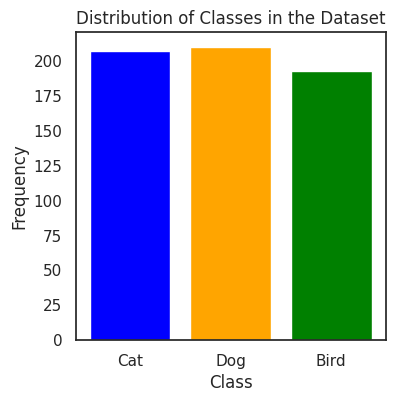

In [ ]:
#Visualizing Distribution of Classes
labels = [label.item() for _, label in dataset]
label_counts = collections.Counter(labels)

plt.figure(figsize=(4, 4))
plt.bar(label_counts.keys(), label_counts.values(), color=['blue', 'orange', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=["Cat", "Dog", "Bird"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Distribution of Classes in the Dataset")
plt.show()

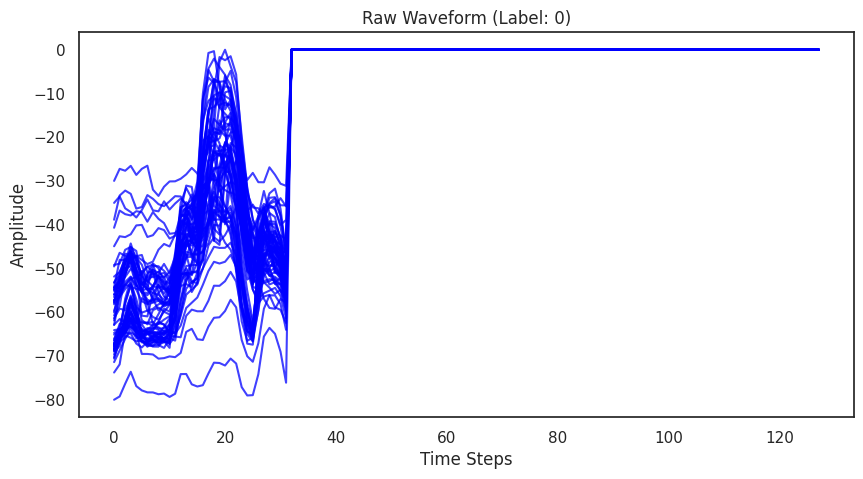

In [ ]:
# Visualizing Raw Waveform
random_idx = random.randint(0, len(dataset) - 1)
waveform, label = dataset[random_idx]
waveform_np = waveform.numpy()
#%%
plt.figure(figsize=(10, 5))
plt.plot(waveform_np.T, alpha=0.75, color='blue')
plt.title(f"Raw Waveform (Label: {label.item()})")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.show()

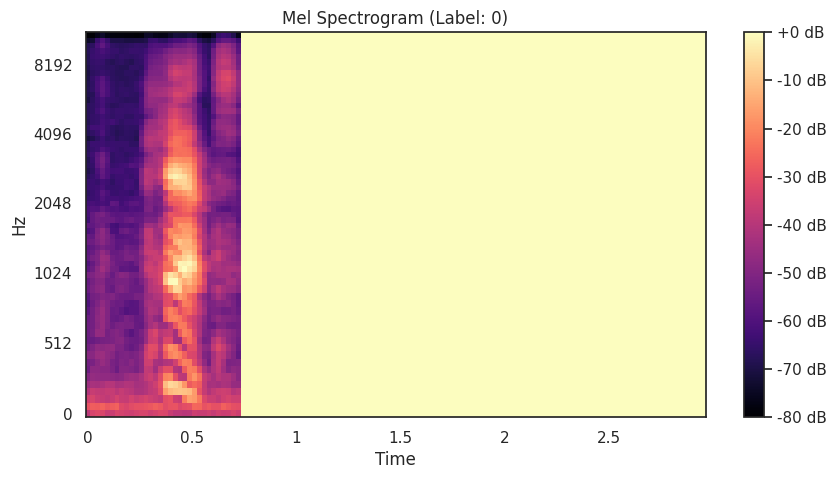

In [ ]:
#Visualizing Mel Spectrogram
mel_spec, label = dataset[random_idx]
mel_spec_np = mel_spec.numpy()

plt.figure(figsize=(10, 5))
librosa.display.specshow(mel_spec_np, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram (Label: {label.item()})")
plt.show()

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("warcoder/cats-vs-dogs-vs-birds-audio-classification")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /root/.cache/kagglehub/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification/versions/1


In [ ]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

In [ ]:
#%%
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
DATASET_PATH=glob("/content/sample_data/animal/*/*.wav")

In [ ]:
#play audio file
ipd.Audio(audio_files[0])

In [ ]:
#y is the raw data of the audio file
#sr is the interger value of sample rate
#sample rate means how many times per second a sound is sampled
y,sr = librosa.load(audio_files[0])
print(f'y:{y[:10]}')
print(f'shape y:{y.shape}')
print(f'sr:{sr}')

y:[-0.00325289 -0.00395116 -0.00357219 -0.00374992 -0.00421285 -0.00491767
 -0.00566369 -0.00573415 -0.0059029  -0.00629869]
shape y:(22050,)
sr:22050


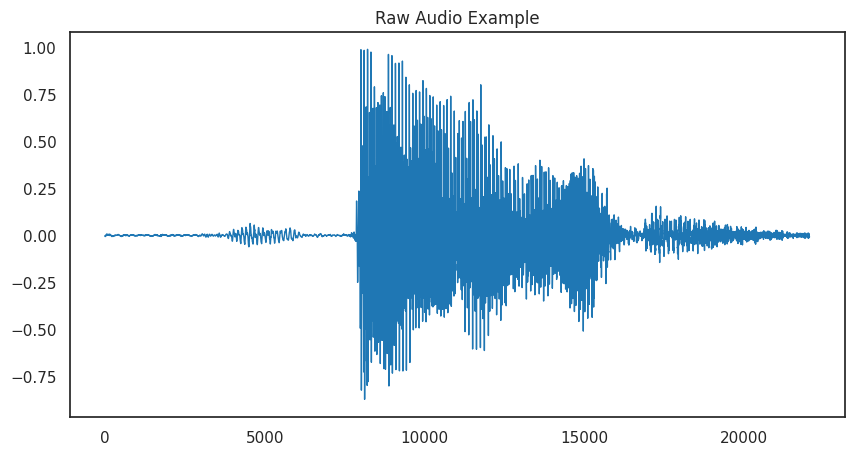

In [ ]:
#lw is line width
pd.Series(y).plot(figsize=(10,5),
                   lw=1 ,
                   title='Raw Audio Example',
                   color=color_pal[0])
plt.show()

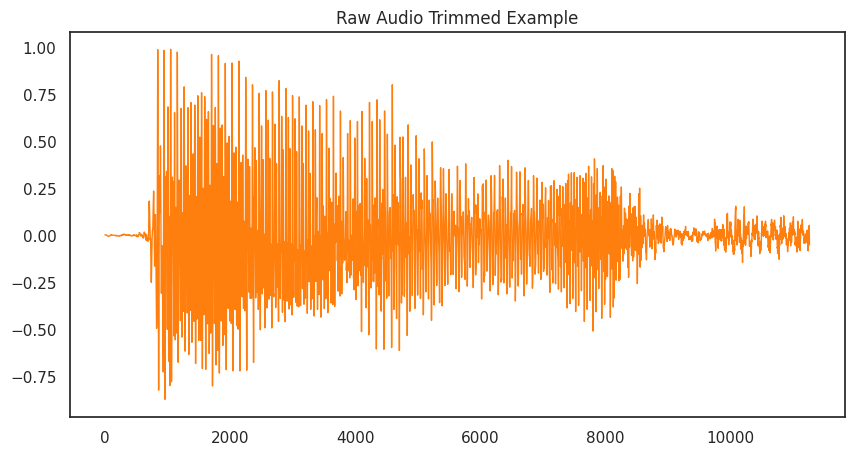

In [ ]:
y_trimmed, _ =librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10,5),
                   lw=1 ,
                   title='Raw Audio Trimmed Example',
                   color=color_pal[1])
plt.show()

In [ ]:
#D for transformed
#S_db sound in decible form
D= librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D) ,ref=np.max)
S_db.shape

(1025, 44)

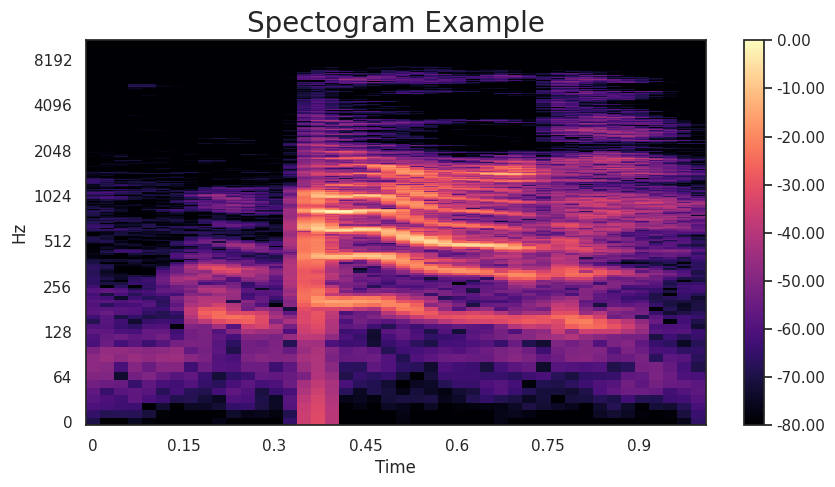

In [ ]:
#plot the transformed audio data
#we can see the different frequencies and over time change in intensity
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db,
                               x_axis='time'
                               ,y_axis='log'
                               ,ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

In [ ]:
#MELL Spectogram(melodic) it is used to transformed to express
#the frequencies that we can hear the audio
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128 *2,)
S_db_mel = librosa.amplitude_to_db(S ,ref=np.max)

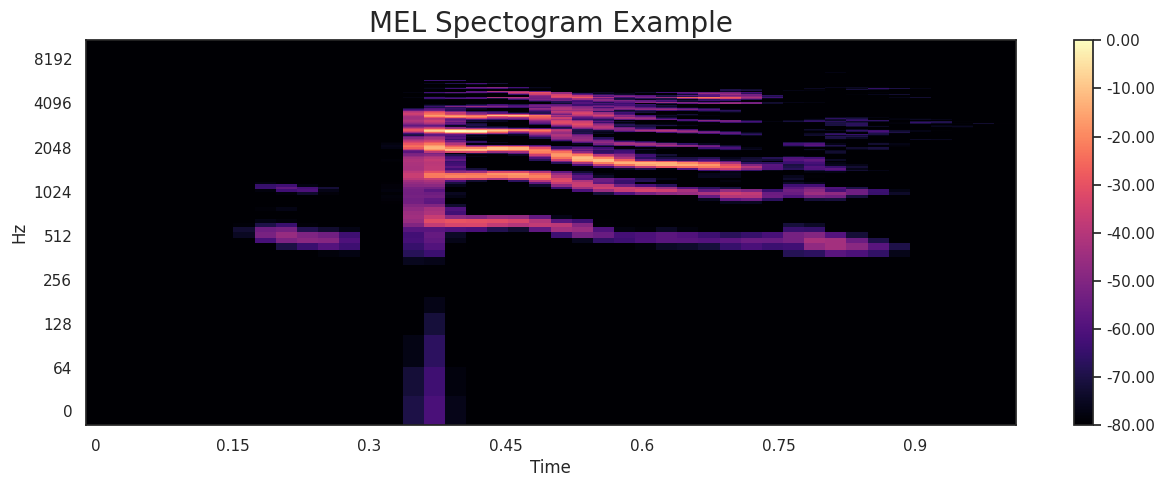

In [ ]:
#plot the mel spectrgram
fig, ax = plt.subplots(figsize=(15,5))
img = librosa.display.specshow(S_db_mel,
                               x_axis='time'
                               ,y_axis='log'
                               ,ax=ax)
ax.set_title('MEL Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

In [ ]:
# Function to load an audio file
def load_audio(filepath):
    waveform, sample_rate = librosa.load(filepath, sr=None)
    return waveform, sample_rate